In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

from tqdm import tqdm

import pyro
import torch
from pyro.infer import SVI, Trace_ELBO, Predictive
import pyro.distributions as dist
from pyro.infer.autoguide.guides import AutoDelta, AutoMultivariateNormal
from pyro.optim import Adam

torch.set_default_tensor_type(torch.cuda.FloatTensor)
pyro.enable_validation(True)

tqdm.pandas()

In [2]:
feature_df = pd.read_csv('../data/features.csv', index_col=0)
# pca = PCA()
# pca.fit(feature_df)
# print(pca.explained_variance_ratio_)

In [3]:
data = torch.from_numpy(feature_df.values)
data = data.type(torch.float32).cuda()

n_factors = 3

In [ ]:
ss = 2000
# factor model according to Bishop - needs some adjustment and description in paper
def factor_model(data):
    W = pyro.param('W', torch.ones((data.shape[-1], n_factors)))
    mu = pyro.param('mu', torch.zeros(data.shape[-1]))
    theta = pyro.sample('theta', dist.HalfCauchy(torch.ones(data.shape[-1])).to_event(1))
    L_omega = pyro.sample('L_omega', dist.LKJCholesky(data.shape[-1], torch.ones(())))
    L_Omega = torch.mm(torch.diag(theta.sqrt()), L_omega)    
    i = 0
    with pyro.plate('data', len(data), subsample_size=ss) as ind:
        i += 1
        batch = data[ind]
        eps = pyro.sample(f'eps_{i}', dist.MultivariateNormal(torch.zeros(data.shape[-1]), scale_tril=L_Omega).expand([ss]))
        z = pyro.sample(f'lat_{i}', dist.MultivariateNormal(torch.zeros(n_factors), torch.eye(n_factors)).expand([ss]))
        pyro.sample(f'obs_{i}', dist.MultivariateNormal(
            (W @ z.permute(1,0)).permute(1,0) + mu + eps, 
            torch.eye(data.shape[-1])).expand([ss]), obs=batch)

In [ ]:
# variational distribution for SVI optimization
def factor_guide(data):
    W_ = pyro.param('W_', torch.ones((n_factors, data.shape[-1])))
    theta_ = pyro.sample('theta', dist.HalfCauchy(torch.ones(data.shape[-1])).to_event(1))
    L_omega_ = pyro.sample('L_omega', dist.LKJCholesky(data.shape[-1], torch.ones(())))
    L_Omega_ = torch.mm(torch.diag(theta_.sqrt()), L_omega_)
    i = 0 
    with pyro.plate('data', len(data), subsample_size=ss) as ind:
        i += 1
        batch = data[ind]
        eps = pyro.sample(f'eps_{i}', dist.MultivariateNormal(torch.zeros(data.shape[-1]), scale_tril=L_Omega_).expand([ss]))
        pyro.sample(f'lat_{i}', dist.MultivariateNormal((W_ @ (batch + eps).permute(1,0)).permute(1,0), torch.eye(n_factors)).expand([ss]))


optimizer = Adam({"lr": 0.005, "betas": (0.9, 0.999)})
svi = SVI(factor_model, factor_guide, optimizer, loss=Trace_ELBO())

n_steps = 100
losses = []
for i in tqdm(range(n_steps)):
    elbo = svi.step(data)
    losses.append(elbo)

In [ ]:
# svi = SVI(factor_model, AutoDelta(factor_model), optimizer, loss=Trace_ELBO())

# n_steps = 1000
# losses = []
# for i in tqdm(range(n_steps)):
#     elbo = svi.step(data)
#     losses.append(elbo)

74525953.9136256 52025231.71525383


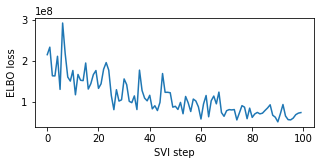

In [24]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

print(losses[-1], min(losses))

In [ ]:
# misc notes
# my guide 15587453918.40625 13617469233.078125
# autodelt 123527770434.49672
# automvn
list(pyro.get_param_store().items())

In [5]:
# sklearn's factor model for comparison
transformer = FactorAnalysis(n_components=3, random_state=0)
latent_features = transformer.fit_transform(feature_df.values)
latent_features = torch.from_numpy(latent_features).type(torch.float32).cuda()

In [3]:
# read games in
df = pd.read_csv('../data/games.csv', index_col=0)
names_to_ids = {n : i for i, n in enumerate(feature_df.index)}
names = names_to_ids.keys()
df = df[df['White'].isin(names) & df['Black'].isin(names)]

features = feature_df.values
res_dict = {
    '1-0': torch.tensor(0),
    '1/2-1/2': torch.tensor(1),
    '0-1': torch.tensor(2)
}

# get list of white player indexes and black player indexes
# w_ids holds the idx of the white player in features so we can look up their latent vars, similar for b_ids
# res holds the result of the games
w_ids = torch.tensor(list(df['White'].apply(lambda x: names_to_ids[x])))
b_ids = torch.tensor(list(df['Black'].apply(lambda x: names_to_ids[x])))
res = torch.tensor(list(df['Result'].apply(lambda x: res_dict[x])))

In [4]:
len(w_ids)

4695527

In [68]:
# batch size
ss = 200

# subset the data to the batch size, ie, only learn on a very small dataset for testing purposes ONLY
w_ids = w_ids[:ss]
b_ids = b_ids[:ss]
res = res[:ss]

# this is the game model as desc in the paper
def game_model(w_ids, b_ids, res):
    A = pyro.param('A', torch.ones((n_factors, n_factors)))
    B = pyro.param('B', torch.ones((n_factors, n_factors)))
    sigma = pyro.sample('sigma', dist.Gamma(1, 0.5).expand([n_factors]).to_event(1))
    
    with pyro.plate('data', len(w_ids), subsample_size=ss) as ind:
        w_batch = latent_features[w_ids[ind]]
        b_batch = latent_features[b_ids[ind]]
        res_batch = res[ind]
        p = pyro.sample('p', dist.MultivariateNormal((A @ w_batch.T).T + (B @ b_batch.T).T, sigma * torch.eye(n_factors)).expand([ss]))
        p_pos = torch.nn.functional.softplus(p)
        p_norm = p_pos / torch.sum(p_pos, 1)[:, None]
        pyro.sample('obs', dist.Categorical(p_norm), obs=res_batch)
        return ind, p_norm

optimizer = Adam({"lr": 0.005, "betas": (0.9, 0.999)})
game_guide = AutoMultivariateNormal(game_model)
svi = SVI(game_model, game_guide, optimizer, loss=Trace_ELBO())

n_steps = 1000
losses = []
for i in tqdm(range(n_steps)):
    elbo = svi.step(w_ids, b_ids, res)
    losses.append(elbo)

100%|██████████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.12it/s]


In [87]:
# pred = Predictive(game_model, guide=game_guide, num_samples=1)(w_ids, b_ids, res)
# computing p_norms
params = pyro.get_param_store()
A = params['A']; B = params['B']
p = (A @ latent_features[w_ids].T).T + (B @ latent_features[b_ids].T).T
p_pos = torch.nn.functional.softplus(p)
p_norm = p_pos / torch.sum(p_pos, 1)[:, None]

In [104]:
# compute E_A according to rating
rating_diff = df['WhiteElo'][:ss] - df['BlackElo'][:ss]
E_A = 1 / (1 + 10 ** (rating_diff / 400))

# compute E_A_hat from model estimates
E_A_est = p_norm[:,0] + 0.5 * p_norm[:,1]

In [105]:
diff_E_A = E_A - E_A_est.cpu().detach().numpy()

In [106]:
counts = df['Result'][:ss].value_counts()
counts['1-0'] + 0.5 * counts['1/2-1/2']

104.5

In [107]:
print(sum(E_A), sum(E_A_est))

102.74535588641909 tensor(101.3834, grad_fn=<AddBackward0>)


In [113]:
np.std(E_A)

0.19223187327739671

In [109]:
# initially much lower variance than E_A, could change as dataset grows
torch.std(E_A_est)

tensor(0.0602, grad_fn=<StdBackward0>)

In [100]:
rating_diff = df['WhiteElo'] - df['BlackElo']
E_A = 1 / (1 + 10 ** (rating_diff / 400))
sum(E_A)

2334809.669280829

In [101]:
counts = df['Result'].value_counts()
counts['1-0'] + 0.5 * counts['1/2-1/2']

2551169.5